<a href="https://colab.research.google.com/github/anshulchawla91/demandforecasting/blob/main/Univariate%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series Forecasting

### Load Dataset

In [83]:
import pandas as pd
import numpy as np

# Load the dataset

def load_dataset(file_path):
  ''' function to load a csv file into a pandas dataframe '''
  df = pd.read_csv(file_path)
  return df


df = load_dataset('/content/drive/MyDrive/Colab Notebooks/Incite AI/acv.csv')

# Display basic information and the first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293310 entries, 0 to 293309
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Market   293310 non-null  int64  
 1   Product  293310 non-null  int64  
 2   ds       293310 non-null  object 
 3   i_acv    293310 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 9.0+ MB


(None,
    Market  Product                        ds  i_acv
 0      50        0  2018-01-07T00:00:00.000Z   0.23
 1      50        0  2018-01-14T00:00:00.000Z   0.23
 2      50        0  2018-01-21T00:00:00.000Z   0.23
 3      50        0  2018-01-28T00:00:00.000Z   0.23
 4      50        0  2018-02-04T00:00:00.000Z   0.26)

There are 4 columns in the dataset, and 293,310 records.


1.   Market as an integer
2.   Product as an integer
3.   Timestamp in object format -- would need to be converted to timestamp
4.   i_acv is a floating point value, and the target variable (the one that needs to be forecasted)




### Data Pre-Processing and EDA

In [101]:
#convert ds from object to datetime format and remove timezone
df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)


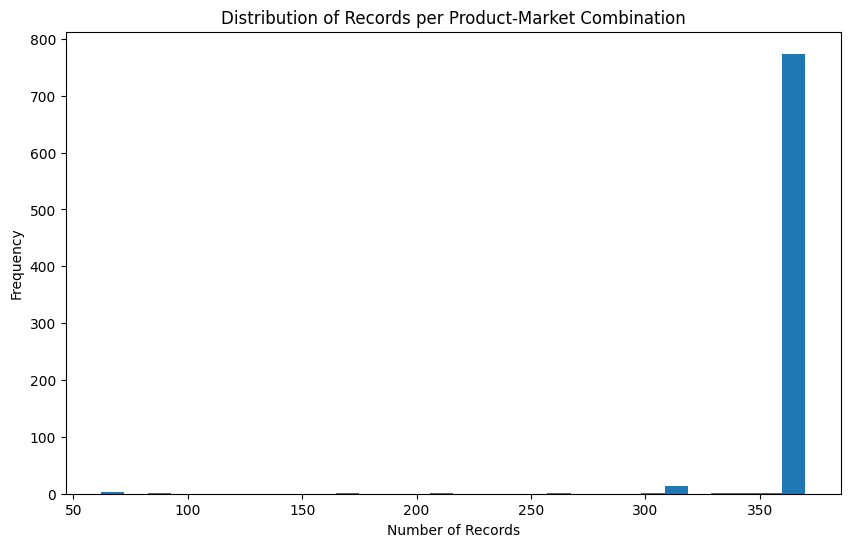

,Product,Market,counts
count,800.000000,800.000000,800.00000
mean,7.393750,28.073750,366.63750
std,4.172586,16.482123,24.85137
min,0.000000,0.000000,62.00000
25%,4.000000,14.000000,370.00000
50%,7.000000,28.000000,370.00000
75%,11.000000,42.000000,370.00000
max,14.000000,56.000000,370.00000


In [102]:
def data_stats_dist_visual(df, key1, key2):

  ''' function to get summary stats and distribution in tabular and
  visual format for a dataframe with 2 keys'''

  # Check the count of records for key1 and key2
  key1_key2_count = df.groupby([key1, key2]).size().reset_index(name='counts')
  summary_stats_table = key1_key2_count.describe()

  # code for generating distribution plot
  import matplotlib.pyplot as plt

  # Create the histogram
  plt.figure(figsize=(10, 6))
  plt.hist(key1_key2_count['counts'], bins=30)  # Adjust the number of bins as needed
  plt.xlabel('Number of Records')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of Records per {key1}-{key2} Combination')
  plt.show()

  return summary_stats_table


data_stats_dist_visual(df, 'Product', 'Market')


Observations:

1.   There are a total of 800 product-market combinations
2.   A vast majority of all product-market combinations have 370 *weekly acv* records -- this means we have over 7 years of data for them.
3.   There are handful number of product-market combinations where we have less than 100 weeks of data, with a minimum of 62 weeks.

Next Steps:

1.   Because the task is to generate forecast for 3-5 product-market combinations only, I will pick random 3-5 product market combinations from those that have the maximum amount of data (370 weeks).



In [103]:
def pick_random_key_records(df, key1, key2, target_variable, num_records):

  ''' function to select a random sample of keys for which forecasts need
  to be generated and filter for their records from a dataframe with 2 keys '''

  # Select a few random key combinations for forecasting -- we pick the keys with the most amount of data
  sample_combinations = df.groupby([key1, key2])[target_variable].count().nlargest(5).index.tolist()

  # Filter data for selected combinations
  df_sample = df[df.set_index([key1, key2]).index.isin(sample_combinations)]

  # Check for missing values
  missing_values = df_sample.isnull().sum()

  # Display summary of the selected sample and missing values
  print(df_sample.groupby([key1, key2]).size())
  print(missing_values)
  return df_sample

df_sample = pick_random_key_records(df, 'Product', 'Market', 'i_acv', 5)

Product  Market
0        0         370
         1         370
         2         370
         3         370
         4         370
dtype: int64
Market     0
Product    0
ds         0
i_acv      0
dtype: int64


Observations:
1. The sample dataset has been created with 5 product-markets containing 370 weeks of data.
2. There are no missing values in this sample.

Next Step: let's visualize the data for these 5 product-market combinations to get a visual assessment of outliers, trend, seasonality.

In [50]:
df_sample.head()

,Market,Product,ds,i_acv
36532,4,0,2018-01-07 00:00:00+00:00,1.43
36533,4,0,2018-01-14 00:00:00+00:00,1.47
36534,4,0,2018-01-21 00:00:00+00:00,1.46
36535,4,0,2018-01-28 00:00:00+00:00,1.48
36536,4,0,2018-02-04 00:00:00+00:00,1.56


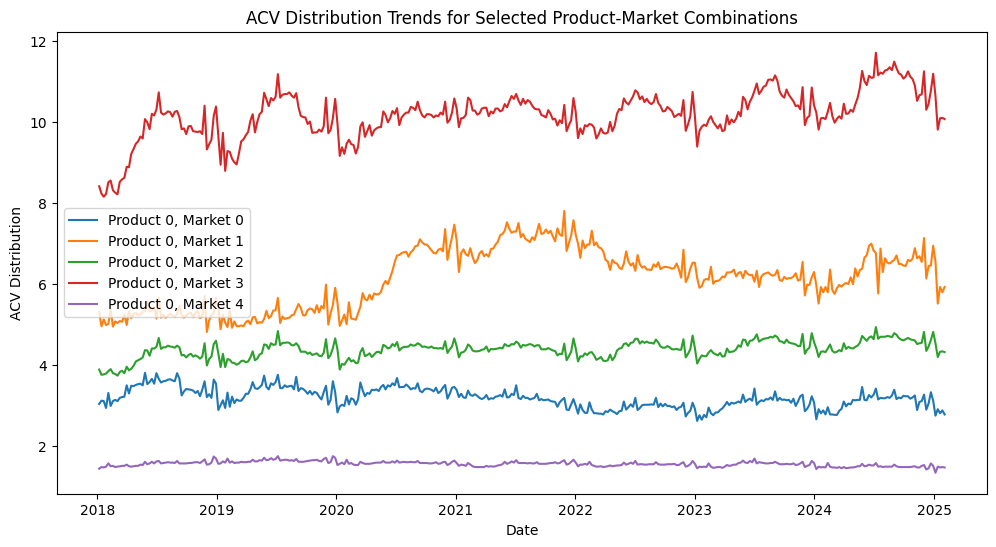

In [104]:
import matplotlib.pyplot as plt

# Plot time series for selected product-market combinations
plt.figure(figsize=(12, 6))

for (product, market), data in df_sample.groupby(['Product', 'Market']):
    plt.plot(data['ds'], data['i_acv'], label=f'Product {product}, Market {market}')

plt.xlabel('Date')
plt.ylabel('ACV Distribution')
plt.title('ACV Distribution Trends for Selected Product-Market Combinations')
plt.legend()
plt.show()

I don't see any outliers, but the data does *look* a bit noisy. Because the requirement is to generate forecast for 18 *months*, I think I am going to aggregate this weekly data into monthly, and see how it looks.

In [105]:
# Convert 'i_acv' from weekly to monthly data
df_sample['ds'] = pd.to_datetime(df_sample['ds'])
df_sample_monthly = df_sample.groupby([pd.Grouper(key='ds', freq='M'), 'Product', 'Market'])['i_acv'].sum().reset_index()
df_sample_monthly.head()

<ipython-input-105-8faa37f2b372>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['ds'] = pd.to_datetime(df_sample['ds'])
<ipython-input-105-8faa37f2b372>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_sample_monthly = df_sample.groupby([pd.Grouper(key='ds', freq='M'), 'Product', 'Market'])['i_acv'].sum().reset_index()


,ds,Product,Market,i_acv
0,2018-01-31,0,0,12.17
1,2018-01-31,0,1,20.35
2,2018-01-31,0,2,15.17
3,2018-01-31,0,3,33.01
4,2018-01-31,0,4,5.84


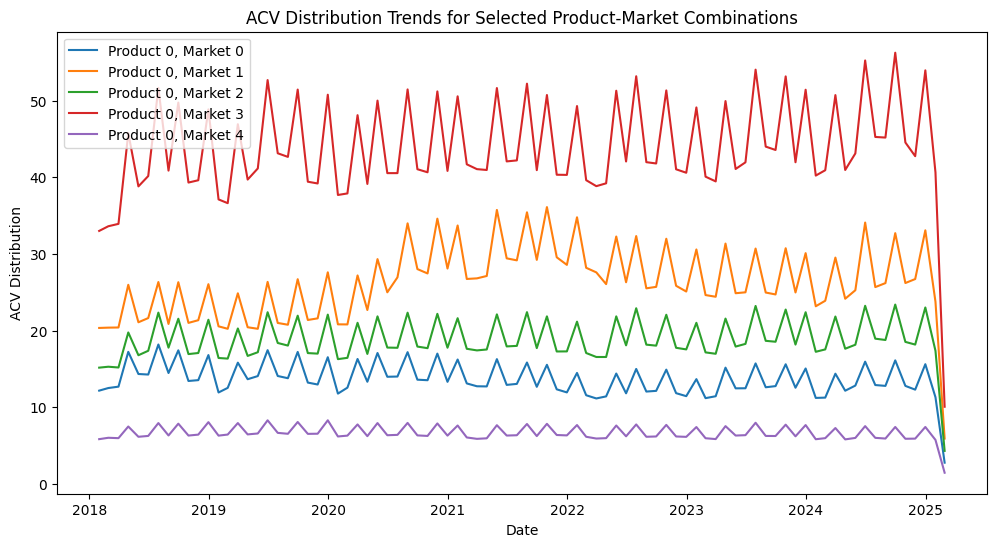

In [106]:
# Plot time series for selected product-market combinations
plt.figure(figsize=(12, 6))

for (product, market), data in df_sample_monthly.groupby(['Product', 'Market']):
    plt.plot(data['ds'], data['i_acv'], label=f'Product {product}, Market {market}')

plt.xlabel('Date')
plt.ylabel('ACV Distribution')
plt.title('ACV Distribution Trends for Selected Product-Market Combinations')
plt.legend()
plt.show()

This seems significantly less noisy. However, I just noticed that I am suppsed to generate *weekly ACV* forecasts. So, let's go to modeling.

## Model Selection

I am going to choose **ARIMA** model for forecasting for the following reasons:

1. It is a *univariate forecasting problem* -- there are no additional features involved. If there were additional external features involved, I would have considered using XGBoost or Random Forest Model.
2. I don't want to use Deep Learning models because I want interpretability of outputs because it is helpful in general for adoption of forecast models. ARIMA is very interpretable.
3. ARIMA can handle trends and seasonality in the data -- which is clearly visible here.
4. ARIMA doesn't have high computational needs, unlike deep learning models like LSTM
5. ARIMA is easy fast and easy to implement.
6. I am not selecting Prophet because I haven't used it in the past, so for the sake of speedy implementation, I will go ahead with ARIMA.


For ARIMA using ARIMA models, we must check to see if the time-series is **stationary**.

### Check if the time-series is **Stationary**

In [107]:
def stationary_check(df, key1, key2, datetime_variable, target_variable):

  ''' function to check if the time-series data in a dataframe with 2 keys is stationary '''

  from statsmodels.tsa.stattools import adfuller

  # Dictionary to store ADF test results for each selected product-market combination
  adf_results = {}

  # Perform ADF test for each selected product-market combination
  for (key1, key2), data in df.groupby([key1, key2]):
      df_selected = data[[datetime_variable, target_variable]].rename(columns={datetime_variable: 'dt', target_variable: 'y'})
      df_selected.set_index('dt', inplace=True)

      # Perform Augmented Dickey-Fuller (ADF) Test
      adf_result = adfuller(df_selected['y'])

      # Store ADF test results
      adf_results[(key1, key2)] = {
          "ADF Statistic": adf_result[0],
          "p-value": adf_result[1],
          "Critical Values": adf_result[4],
          "Is Stationary": adf_result[1] < 0.05  # If p-value < 0.05, data is stationary
      }

  # Display results
  return adf_results



In [76]:
stationary_check(df_sample, 'Product', 'Market', 'ds', 'i_acv')

{(0, 0): {'ADF Statistic': -2.742077961553531,
  'p-value': 0.06703565187826518,
  'Critical Values': {'1%': -3.448645946352023,
   '5%': -2.869602139060357,
   '10%': -2.5710650077160495},
  'Is Stationary': False},
 (0, 1): {'ADF Statistic': -1.669661156688767,
  'p-value': 0.446807822988196,
  'Critical Values': {'1%': -3.4483935212959844,
   '5%': -2.8694912343676497,
   '10%': -2.571005879151811},
  'Is Stationary': False},
 (0, 2): {'ADF Statistic': -4.868577626140641,
  'p-value': 4.013339300529288e-05,
  'Critical Values': {'1%': -3.44880082033912,
   '5%': -2.869670179576637,
   '10%': -2.5711012838861036},
  'Is Stationary': True},
 (0, 3): {'ADF Statistic': -4.851706904583134,
  'p-value': 4.3263432320584594e-05,
  'Critical Values': {'1%': -3.4485948978753314,
   '5%': -2.86957971128312,
   '10%': -2.571053050314224},
  'Is Stationary': True},
 (0, 4): {'ADF Statistic': -1.9597160039589512,
  'p-value': 0.3045106047339338,
  'Critical Values': {'1%': -3.4489583388155194,
  

Observation: 3 out of 5 product-market combinations time-series are **NOT** stationary, which was also somewhat visible in the charts above.

Next Step: instead of manually making the 3 time-series stationary, I can use **AutoARIMA** to automate the process of making them stationary, and parameter tuning. However, I think AutoARIMA could be very slow.

### Implement **AutoARIMA**

1. Split the data into train and test and measure MAE
2. Compute evaluation metrics -- RMSE and MAR
3. Plot forecast vs. actual for every product-market

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

# Define forecasting horizon
forecast_horizon = 78  # 18 months (78 weeks)

# Store RMSE scores
rmse_scores = {}

#Store MAE scores
mae_scores = {}

# Train AutoARIMA and evaluate for each selected product-market combination
for (product, market), data in df_sample.groupby(['Product', 'Market']):
    # Prepare data
    df_auto_arima = data[['ds', 'i_acv']].rename(columns={'ds': 'ds', 'i_acv': 'y'})
    df_auto_arima.set_index('ds', inplace=True)

    # Split data into training and testing sets (80% train, 20% test)
    train_size = int(0.8 * len(df_auto_arima))
    train, test = df_auto_arima.iloc[:train_size], df_auto_arima.iloc[train_size:]

    # Fit AutoARIMA model
    model = auto_arima(train,
                   seasonal=True,
                   m=52,
                   stepwise=True,  # Ensures a faster stepwise search
                   max_p=3, max_q=3,  # Limits search space for AR & MA terms
                   max_P=2, max_Q=2,  # Limits seasonal parameters
                   max_d=1, max_D=1,  # Limits differencing to speed up processing
                   trace=True,  # Enables logging to see progress
                   suppress_warnings=True)

    # Forecast on the test set
    test_forecast = model.predict(n_periods=len(test))

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(test, test_forecast))
    rmse_scores[(product, market)] = rmse

    #Compute MAE
    mae = mean_absolute_error(test, test_forecast)
    mae_scores[(product, market)] = mae

    # Store actual vs forecast data for visualization
    test_forecast_df = pd.DataFrame({'ds': test.index, 'actual': test['y'].values, 'forecast': test_forecast})

    # Plot actual vs forecast for test data
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test['y'], label="Actual", color="green")
    plt.plot(test.index, test_forecast, label="Test Forecast", color="blue", linestyle="dashed")
    plt.xlabel("Date")
    plt.ylabel("ACV Distribution")
    plt.title(f"AutoARIMA Test Forecast vs Actual - Product {product}, Market {market}")
    plt.legend()
    plt.show()



# Print RMSE scores
print("RMSE Scores for AutoARIMA Forecasts:")
for key, value in rmse_scores.items():
    print(f"Product {key[0]}, Market {key[1]}: RMSE = {value:.4f}")

# Print MAE scores
print("MAE Scores for AutoARIMA Forecasts:")
for key, value in mae_scores.items():
    print(f"Product {key[0]}, Market {key[1]}: MAE = {value:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=-479.954, Time=19.18 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-275.311, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=4.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-443.462, Time=8.31 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-277.296, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=-453.746, Time=17.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=-480.004, Time=19.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=-386.925, Time=0.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=-478.179, Time=97.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=-476.167, Time=110.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=-475.997, Time=16.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[52] intercept   : AIC=-476.565, Time=15.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,0)[52] intercept   : AIC=-478.110, Time=21.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,0)[52] intercept   : AIC=-477.927, Time=25.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=-473.233, Time=13.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,0)[52] intercept   : AIC=-479.214, Time=18.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[52] intercept   : AIC=-474.718, Time=18.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,0)[52] intercept   : AIC=-474.495, Time=22.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[52]             : AIC=-481.995, Time=10.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[52]             : AIC=-388.891, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[52]             : AIC=-482.243, Time=45.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[52]             : AIC=inf, Time=99.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[52]             : AIC=-482.695, Time=18.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[52]             : AIC=-455.706, Time=13.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

As expected, AutoARIMA seems to be very slow b/c it is trying out multiple combinations, and it can't utilize GPUs or multi-threads on CPU.

I learned that Prophet is **NOT** a Deep Learning model, and is actually a very interpretable statistical model, and apparently, much faster than AutoARIMA. So I am going to try that.

### Implement **Prophet**

1. Split the data into train and test and measure MAE
2. Compute evaluation metrics -- RMSE and MAR
3. Plot forecast vs. actual for every product-market

I will generate forecasts for the next 18 months after this.

In [96]:
pip install prophet

<ipython-input-109-fc2a635355a9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['ds'] = pd.to_datetime(df_sample['ds']).dt.tz_localize(None)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/8j9ogag9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/u5c1sxpw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10638', 'data', 'file=/tmp/tmpiw3c38zh/8j9ogag9.json', 'init=/tmp/tmpiw3c38zh/u5c1sxpw.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_model5ymfs97v/prophet_model-2025020815310

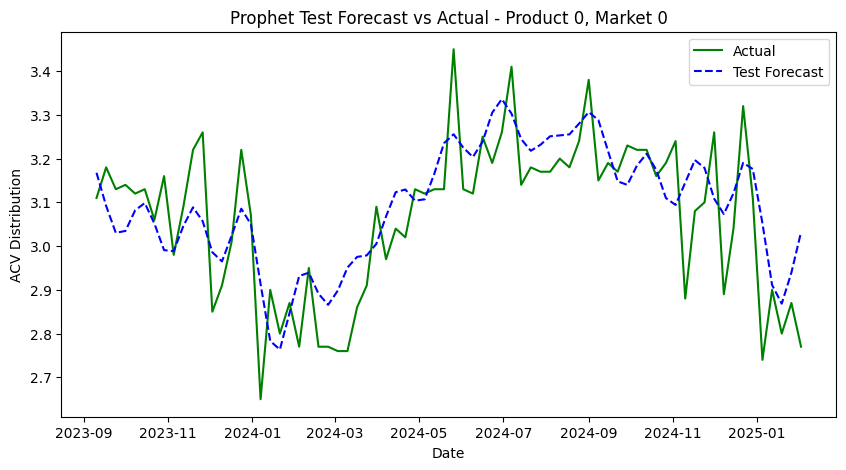

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/z05_ezkp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/a00bne1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1666', 'data', 'file=/tmp/tmpiw3c38zh/z05_ezkp.json', 'init=/tmp/tmpiw3c38zh/a00bne1_.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_model80trwaxf/prophet_model-20250208153108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


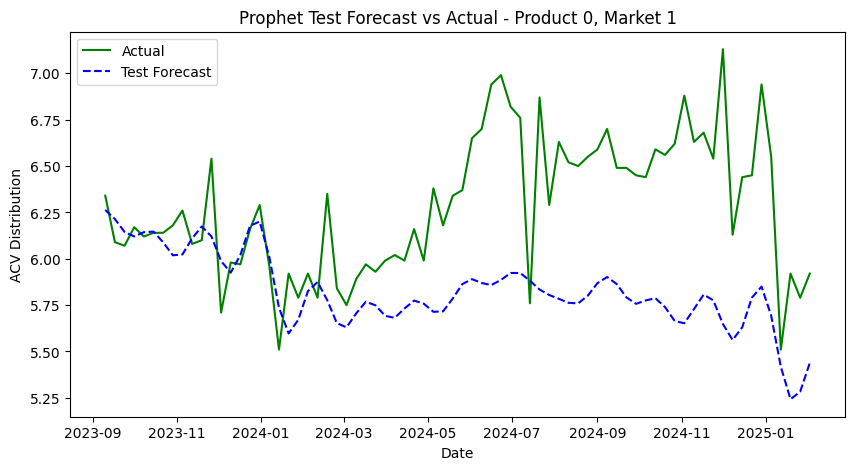

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/m5s1tn23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/o5luxn24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92701', 'data', 'file=/tmp/tmpiw3c38zh/m5s1tn23.json', 'init=/tmp/tmpiw3c38zh/o5luxn24.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_model1jog4c19/prophet_model-20250208153109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:31:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


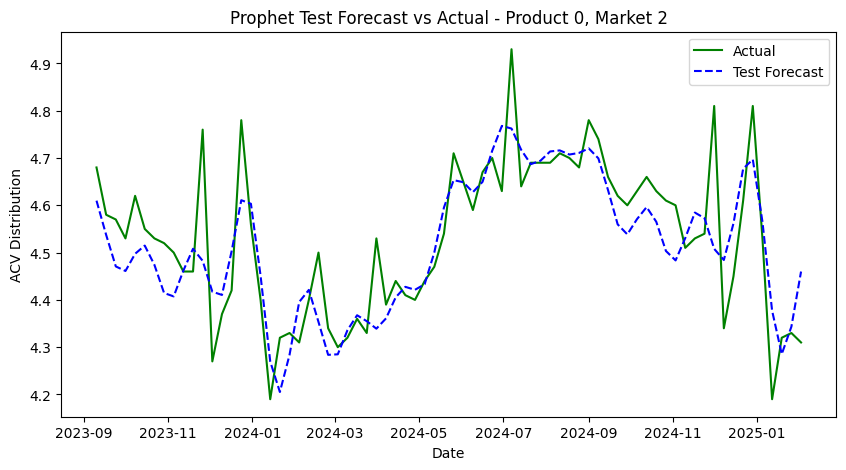

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/xay3cn4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/rqnm03jx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16113', 'data', 'file=/tmp/tmpiw3c38zh/xay3cn4p.json', 'init=/tmp/tmpiw3c38zh/rqnm03jx.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_model36kdezmn/prophet_model-20250208153110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:31:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


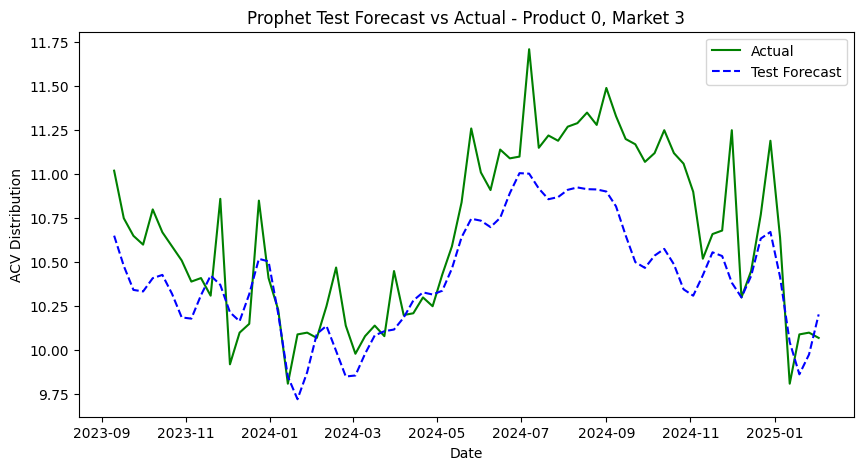

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/v689ctp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/y_9gu3de.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43531', 'data', 'file=/tmp/tmpiw3c38zh/v689ctp7.json', 'init=/tmp/tmpiw3c38zh/y_9gu3de.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_model9614euow/prophet_model-20250208153111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


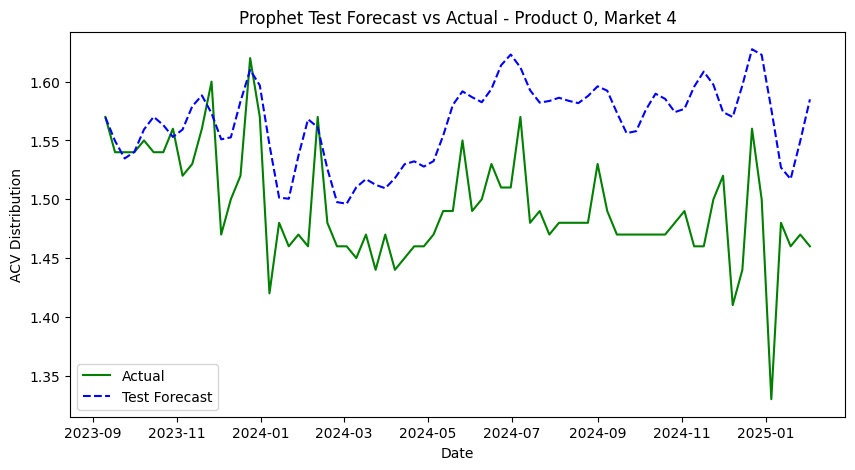


RMSE Scores for Prophet Forecasts:
Product 0, Market 0: RMSE = 0.1134
Product 0, Market 1: RMSE = 0.6039
Product 0, Market 2: RMSE = 0.0914
Product 0, Market 3: RMSE = 0.3492
Product 0, Market 4: RMSE = 0.0857

MAE Scores for Prophet Forecasts:
Product 0, Market 0: MAE = 0.0920
Product 0, Market 1: MAE = 0.4849
Product 0, Market 2: MAE = 0.0685
Product 0, Market 3: MAE = 0.2820
Product 0, Market 4: MAE = 0.0735


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Store results
rmse_scores = {}
mae_scores = {}
forecast_results = {}

# Train Prophet on train set, evaluate on test set
for (product, market), data in df_sample.groupby(['Product', 'Market']):
    # Prepare data
    df_prophet = data[['ds', 'i_acv']].rename(columns={'ds': 'ds', 'i_acv': 'y'})

    # Split data into training (80%) and testing (20%)
    train_size = int(0.8 * len(df_prophet))
    train, test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]

    # Initialize and fit Prophet model on training data
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(train)

    # Create future dataframe for test period
    future_test = model.make_future_dataframe(periods=len(test), freq='W')

    # Forecast the test set
    forecast_test = model.predict(future_test)
    forecast_test = forecast_test[['ds', 'yhat']].set_index('ds').loc[test['ds']]

    # Compute RMSE and MAE for test set
    rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
    mae = mean_absolute_error(test['y'], forecast_test['yhat'])
    rmse_scores[(product, market)] = rmse
    mae_scores[(product, market)] = mae

    # Plot actual vs forecast for test data
    plt.figure(figsize=(10, 5))
    plt.plot(test['ds'], test['y'], label="Actual", color="green")
    plt.plot(forecast_test.index, forecast_test['yhat'], label="Test Forecast", color="blue", linestyle="dashed")
    plt.xlabel("Date")
    plt.ylabel("ACV Distribution")
    plt.title(f"Prophet Test Forecast vs Actual - Product {product}, Market {market}")
    plt.legend()
    plt.show()

# Print RMSE and MAE scores
print("\nRMSE Scores for Prophet Forecasts:")
for key, value in rmse_scores.items():
    print(f"Product {key[0]}, Market {key[1]}: RMSE = {value:.4f}")

print("\nMAE Scores for Prophet Forecasts:")
for key, value in mae_scores.items():
    print(f"Product {key[0]}, Market {key[1]}: MAE = {value:.4f}")


Observations:
1. Prophet model is MUCH faster than AutoARIMA
2. The visual fit seems decent for all product-market combinations except Product 0 Market 1
3. It is also reflected in RMSE and MAE values for Product 0, Market 1.
4. I am a little concerned about **potential overfitting** in Product 0 Market 2

### Implement code to generate forecast for next 18 months

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/pju6z_5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/64yrztpy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1355', 'data', 'file=/tmp/tmpiw3c38zh/pju6z_5t.json', 'init=/tmp/tmpiw3c38zh/64yrztpy.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_modelycrbncw6/prophet_model-20250208153907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


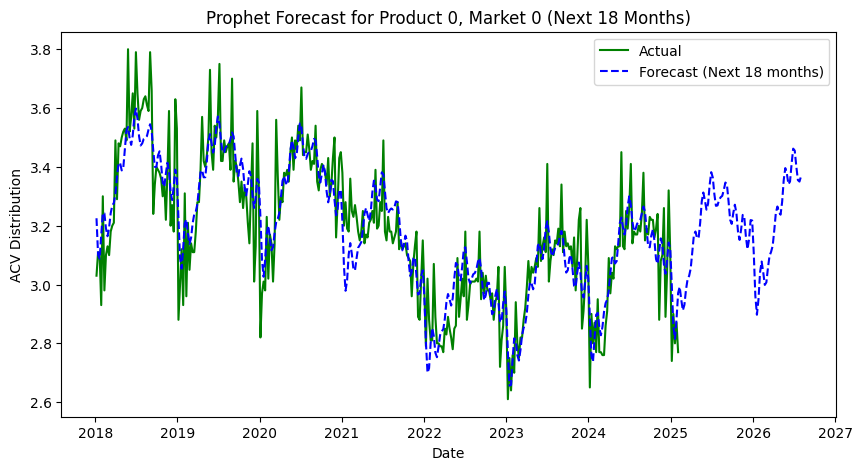

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/aixdch6e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/3jhqt0xt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98756', 'data', 'file=/tmp/tmpiw3c38zh/aixdch6e.json', 'init=/tmp/tmpiw3c38zh/3jhqt0xt.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_modeli63uho_0/prophet_model-20250208153907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


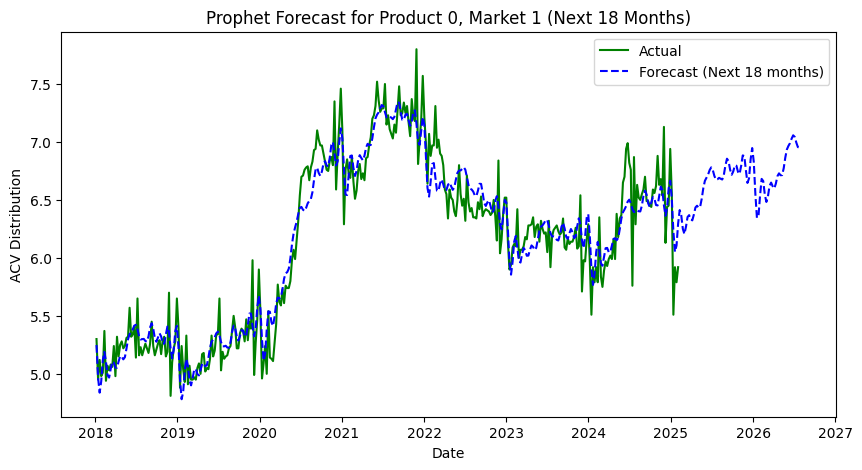

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/ohjgh4c1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/k87de4dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85880', 'data', 'file=/tmp/tmpiw3c38zh/ohjgh4c1.json', 'init=/tmp/tmpiw3c38zh/k87de4dc.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_modelvu68_vhg/prophet_model-20250208153908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


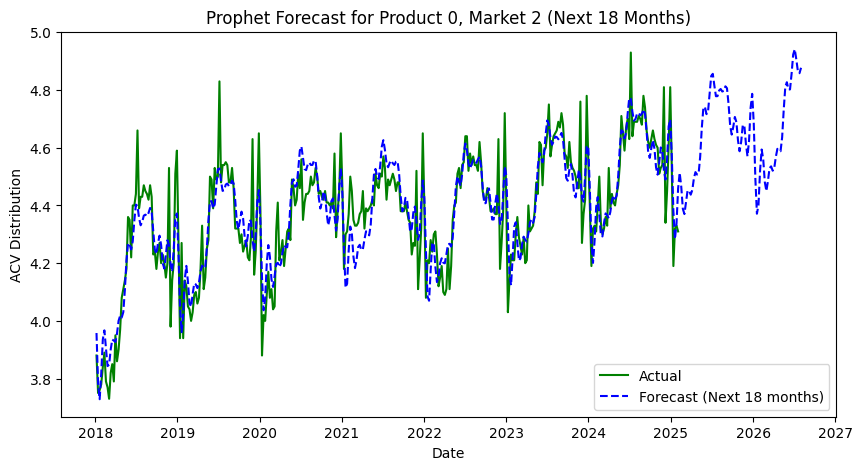

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/euvkk1xl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/wnpg80zd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24837', 'data', 'file=/tmp/tmpiw3c38zh/euvkk1xl.json', 'init=/tmp/tmpiw3c38zh/wnpg80zd.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_modeljab8aitq/prophet_model-20250208153909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


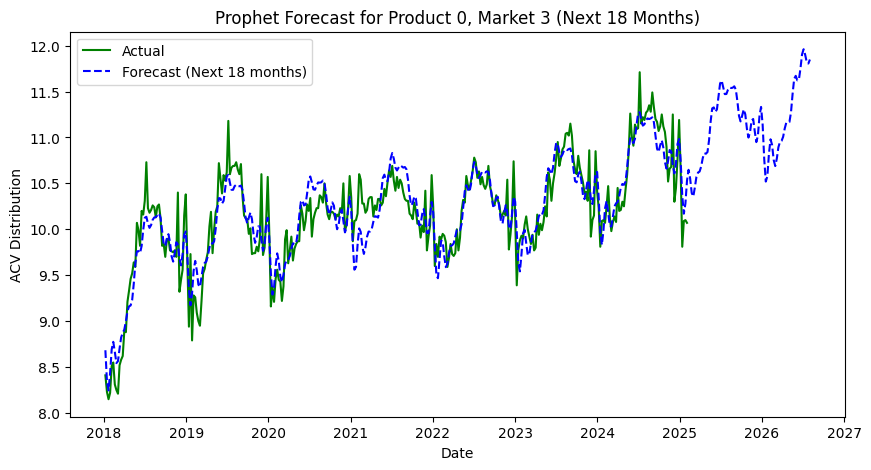

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/oh7z7bm_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw3c38zh/t8dcaayu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70381', 'data', 'file=/tmp/tmpiw3c38zh/oh7z7bm_.json', 'init=/tmp/tmpiw3c38zh/t8dcaayu.json', 'output', 'file=/tmp/tmpiw3c38zh/prophet_modelapm85k42/prophet_model-20250208153909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


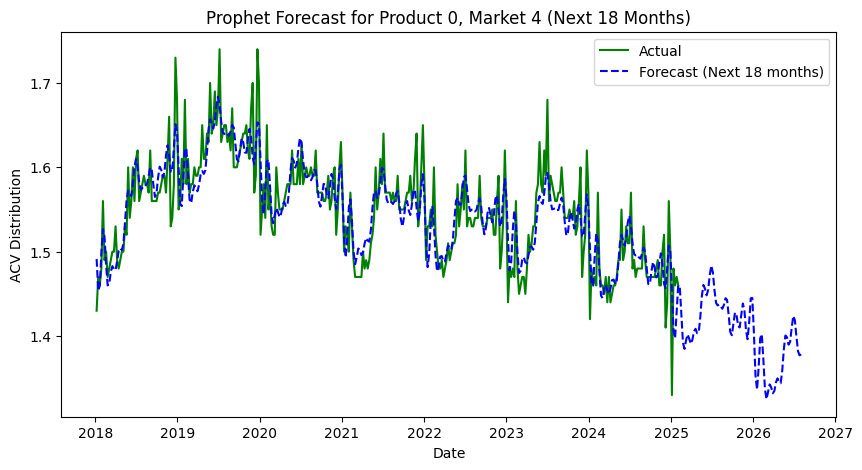

In [110]:
# Define forecasting horizon
forecast_horizon = 78  # 18 months (78 weeks)

forecast_results = {}

# Train Prophet on full set and forecast next 18 months
for (product, market), data in df_sample.groupby(['Product', 'Market']):
    # Prepare data
    df_prophet = data[['ds', 'i_acv']].rename(columns={'ds': 'ds', 'i_acv': 'y'})

    model_full = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model_full.fit(df_prophet)

    # Create future dataframe for next 18 months
    future_forecast = model_full.make_future_dataframe(periods=forecast_horizon, freq='W')

    # Forecast next 18 months
    forecast_future = model_full.predict(future_forecast)
    forecast_results[(product, market)] = forecast_future

    # Plot actual vs future forecast
    plt.figure(figsize=(10, 5))
    plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual", color="green")
    plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast (Next 18 months)", color="blue", linestyle="dashed")
    plt.xlabel("Date")
    plt.ylabel("ACV Distribution")
    plt.title(f"Prophet Forecast for Product {product}, Market {market} (Next 18 Months)")
    plt.legend()
    plt.show()

Observations:
1. For product 0, market 4, the model is able to capture the declining trend and the seasonal peaks in the forecasts.
2. For product 0, market 3 and 2, the model is able to capture the positive trend and the seasonal peaks in the forecasts.
3. For product 0, market 1, the historical sales pattern is very volatile, so it is difficult to predict using univariate models. **I would recommend adding exploring external features to generate more reliable forecasts for this item.**